In [25]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.linalg as LA

In [26]:

def steady_state(k_matrix):
    """Compute steady state for a system y'=Ay"""
    w, v = LA.eig(k_matrix) # evecs & evals
    return np.abs(v[:, np.argmin(np.abs(w))]) # return evec with smallest eval

In [27]:
A = np.array([[-1,1],[1,-1]])

steady_state(A)

array([0.70710678, 0.70710678])

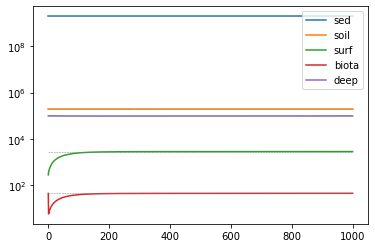

In [28]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.linalg as LA

# functions:
def fill_hollow(matrix):
    """Sets diagonal entries so each column sums to zero."""
    matrix -= np.diag(matrix.sum(axis=0))

def row_col_test(matrix):
    """True if all columns and rows sum to zero."""
    return matrix.sum(axis=0) == matrix.sum(axis=1) == 0

def steady_state(k_matrix):
    """Compute steady state for a system y'=Ay"""
    w, v = LA.eig(k_matrix)
    return v[:, np.argmin(np.abs(w))]

# reservoir names
boxes = ["sed", "soil", "surf", "biota", "deep"]
# number of boxes
N = len(boxes)

# for readable indexing
sed, soil, surf, biota, deep = np.arange(N)

# reservoir magnitute at steady state (Tg P)
reservoir_ss = np.array([2e9, 2e5, 2800, 44, 1e5])
total = reservoir_ss.sum()

# initialize flux matrix
P_flux = np.zeros((N,N))

# dependencies for flux definitions
weathering_rate = 2e4 # Tg sediment /yr
crustal_p_abundance = 0.001 # g P /g sediment
insol_frac = 0.9

redfield_C_P_molar = 106
P_molar_mass = 31 # g /mol
C_molar_mass = 12 # g /mol
redfield_C_P_mass = redfield_C_P_molar * C_molar_mass / P_molar_mass

gross_surf_prod = 4e4 # Tg C /yr

remin_frac = .96

vert_exchange = 2 # m /yr
surf_p_conc = 0.025 # g /m^3
deep_p_conc = 0.080 # g /m^3
ocean_surf_area = 3.5e14 # m^2
g_to_Tg = 1e12 # g /Tg

# define well constrained fluxes based on parameters
# entries set according to P_flux[TO,FROM]
P_flux[sed,soil] = weathering_rate * crustal_p_abundance * insol_frac
P_flux[surf,soil] = weathering_rate * crustal_p_abundance * (1 - insol_frac)
P_flux[biota,surf] = gross_surf_prod / redfield_C_P_mass
P_flux[surf,biota] = P_flux[biota,surf] * remin_frac
P_flux[deep,biota] = P_flux[biota,surf] * (1 - remin_frac)
P_flux[deep,surf] = vert_exchange * surf_p_conc * ocean_surf_area / g_to_Tg
P_flux[surf,deep] = vert_exchange * deep_p_conc * ocean_surf_area / g_to_Tg

# define poorly constrained fluxes based on steady state
P_flux[sed,deep] = (P_flux.sum(axis=1)-P_flux.sum(axis=0))[deep]
P_flux[soil,sed] = (P_flux.sum(axis=1)-P_flux.sum(axis=0))[sed]

# fill diagonal terms
fill_hollow(P_flux)

# fluxes at steady state (Tg P /y)
flux_ss = np.array([[ 0, 18,   0,   0,  2],
                    [20,  0,   0,   0,  0],
                    [ 0,  2,   0, 940, 56],
                    [ 0,  0, 980,   0,  0],
                    [ 0,  0,  18,  40,  0]])

# fill diagonal terms of flux_ss matrix
fill_hollow(flux_ss)

# flux (Tg P /yr) to linear rate constants (/yr)
# divide each column of P_flux by entry in vector of reservoir sizes
K = P_flux / reservoir_ss

# constant coeff. unforced system y' = Ky
def unforced_const_coeff(y, t):
    return K @ y

# time-dependent forcing from Table 1 Avigad & Gvirtzman (2009)
erosion_forcing = {
    'time': np.array([635.0, 630.0, 615.0, 600.0, 530.0]), # Ma
    'crustal_thickness': np.array([50, 50, 42, 37, 35]), # km
    'mantle_lith_thickness': np.array([150, 0, 55, 85, 100]), # km
    'moho_temp': np.array([3, 1300, 900, 850, 650]), # deg C
    'crust_topo_contrib': np.array([-2.3, 3, 2.2, 1.7, 1.5]),
    'mantle_topo_contrib': np.array([0, 0, -0.5, -0.75, -1.3]),
    'calc_topo': np.array([0.5, 3, 1.7, 0.95, 0.2, ]),
}

erosion_forcing['time'] *= -1.0e9 # convert Ma to years

erosion_time_years = np.arange(erosion_forcing['time'][0], erosion_forcing['time'][-1], 100000)

interpolated_topo = interp1d(erosion_forcing['time'], erosion_forcing['calc_topo'])

def general(y, t):
    A = K
    b = np.zeros(N)
    return A @ y + b

# initial reservoir conditions
reservoir_init = np.array([2e9, 2e5, 280, 44, 1e5]) # Tg P

# scale to match global magnitude
reservoir_init *= (total / reservoir_init.sum())

# time interval
t_int = np.arange(1e3) # yr

# solver
solution = odeint(unforced_const_coeff, reservoir_init, t_int)

# ss solution for plot comparison
solution_ss = np.tile(reservoir_ss, len(t_int)).reshape(len(t_int), N)

# plot
fig, ax = plt.subplots()
ax.plot(solution)
ax.set_yscale('log')
plt.legend(boxes, loc='upper right')
ax.plot(solution_ss, "--", linewidth=0.5, color='grey')

In [29]:
steady_state(flux_ss / reservoir_ss) / reservoir_ss

array([-4.99999997e-10, -4.99999997e-10, -4.99999997e-10, -4.99999997e-10,
       -4.99999997e-10])

In [30]:
erosion_time_years

array([-6.350000e+11, -6.349999e+11, -6.349998e+11, ..., -5.300003e+11,
       -5.300002e+11, -5.300001e+11])

In [31]:
len(erosion_time_years)

1050000

In [32]:
print(interpolated_topo)